In [10]:
include("../src/HPFEM.jl")

HPFEM

In [65]:
nel = 2
nnodes = nel + 1
idir = [1]#,nnodes]
M = 3
Q = M+2
bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [66]:
mp = [5 1 3;
      1 2 4]'


3x2 Array{Int64,2}:
 5  1
 1  2
 3  4

In [67]:
a = 0.0
b = π
nodes = collect(linspace(a, b, nnodes))

3-element Array{Float64,1}:
 0.0    
 1.5708 
 3.14159

In [68]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [69]:
Me = [HPFEM.mass_matrix(bas, el) for el in elems]

2-element Array{Array{T<:Number,2},1}:
 3x3 Array{Float64,2}:
 0.523599  0.261799  0.1309   
 0.261799  0.523599  0.1309   
 0.1309    0.1309    0.0523599
 3x3 Array{Float64,2}:
 0.523599  0.261799  0.1309   
 0.261799  0.523599  0.1309   
 0.1309    0.1309    0.0523599

In [70]:
A = zeros(5,5)
for e = 1:nel
    for i = 1:M
        ig = mp[i,e]
        for k = 1:M
            kg = mp[k,e]
            A[kg,ig] += Me[e][k,i]
        end
    end
end
A

5x5 Array{Float64,2}:
 1.0472    0.261799  0.1309     0.1309     0.261799
 0.261799  0.523599  0.0        0.1309     0.0     
 0.1309    0.0       0.0523599  0.0        0.1309  
 0.1309    0.1309    0.0        0.0523599  0.0     
 0.261799  0.0       0.1309     0.0        0.523599

In [71]:
lft = HPFEM.DirichiletLift(A, [5])

HPFEM.DirichiletLift{Float64}(5,4,1,4x1 Array{Float64,2}:
 0.261799
 0.0     
 0.1309  
 0.0     ,[1,2,3,4],[5])

In [72]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = cos(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
Fe[1,1] = 1.0



1.0

In [73]:
F = zeros(5)
for e = 1:nel
    for i = 1:M
        ig = mp[i,e]
        F[ig] += Fe[i,e]
    end
end
F
        

5-element Array{Float64,1}:
  1.11022e-16
 -0.63662    
  0.17395    
 -0.17395    
  1.0        

In [74]:
Ahh = A[1:4,1:4]
Ahd = A[1:4,5:5]

4x1 Array{Float64,2}:
 0.261799
 0.0     
 0.1309  
 0.0     

In [75]:
F5 = 1.0
Fh = F[1:4] - Ahd*F[5]

4x1 Array{Float64,2}:
 -0.261799 
 -0.63662  
  0.0430507
 -0.17395  

In [76]:
F2 = copy(F)
F2[5] = 1.0
HPFEM.lift!(lft, F2)
F2[1:4]

4-element Array{Float64,1}:
 -0.261799 
 -0.63662  
  0.0430507
 -0.17395  

In [77]:
Uh = Ahh\Fh

4x1 Array{Float64,2}:
 -0.00484811
 -1.02909   
  0.834327  
 -0.737365  

In [78]:
U = [Uh; F5]

5x1 Array{Float64,2}:
 -0.00484811
 -1.02909   
  0.834327  
 -0.737365  
  1.0       

In [79]:
# Scatter
Ue = zeros(M, nel)
for e = 1:nel
    for i = 1:M
        ig = mp[i,e]
        Ue[i,e] = U[ig]
    end
end
Ue

3x2 Array{Float64,2}:
  1.0         -0.00484811
 -0.00484811  -1.02909   
  0.834327    -0.737365  

In [80]:
nξ = 101
ξ = collect(linspace(-1,1, nξ))
x = [(1-ξ)*el.a/2 + (1+ξ)*el.b/2 for el in elems]
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end
Uh = ϕ*Ue;

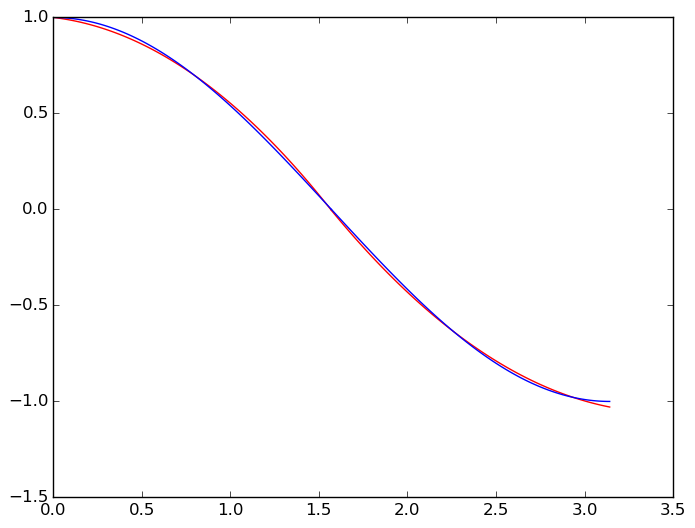

In [81]:
using PyPlot
for e = 1:nel
    plot(x[e], Uh[:,e], "r", x[e], cos(x[e]), "b")
end

In [82]:
# Using static condensation.
